In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from scripts import *

In [3]:
%store -r df_merged
df_merged

,T,T_a,Ff,N,Nh,Cl,Po,U,Ch,Cm,...,RRR,DD_,diff,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3
2012-11-01 00:00:00,-1.9,-6.0,3.0,0.0,NaN,10,763.7,75.0,NaN,NaN,...,NaN,North,4.1,4.1,-4.8,-4.0,-4.0,-4.266667,2.366667,2.366667
2012-11-01 03:00:00,-3.7,-7.0,2.0,10.0,10.0,7,764.9,83.0,"Перистых, перисто-кучевых или перисто-слоистых...","Высококучевые просвечивающие, расположенные на...",...,NaN,North,3.3,3.3,-5.4,-5.8,-4.7,-5.300000,1.600000,1.600000
2012-11-01 06:00:00,-5.1,-7.0,1.0,100.0,0.0,7,766.4,90.0,"Перистые нитевидные, иногда когтевидные, не ра...","Высококучевых, высокослоистых или слоисто-дожд...",...,NaN,North,1.9,1.9,-6.9,-6.4,-7.5,-6.933333,1.833333,1.833333
2012-11-01 09:00:00,-6.6,-8.0,1.0,0.0,NaN,10,767.6,94.0,NaN,NaN,...,Осадков нет,North,1.4,1.4,-6.9,-7.6,-8.1,-7.533333,0.933333,0.933333
2012-11-01 12:00:00,0.9,0.0,1.0,100.0,0.0,7,768.6,64.0,"Перисто-кучевые одни или перисто-кучевые, сопр...","Высококучевых, высокослоистых или слоисто-дожд...",...,NaN,West,0.9,0.9,0.0,-0.4,0.0,-0.133333,1.033333,1.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,-24.0,3.0,100.0,100.0,7,755.8,79.0,NaN,Высокослоистые просвечивающие.,...,Следы осадков,East,-1.8,1.8,-26.5,-22.8,-27.2,-25.500000,-0.300000,0.300000
2021-02-28 12:00:00,-20.7,-20.0,4.0,100.0,0.0,7,753.9,81.0,Перистые (часто в виде полос) и перисто-слоист...,"Высококучевых, высокослоистых или слоисто-дожд...",...,NaN,East,-0.7,0.7,-20.9,-20.4,-21.1,-20.800000,0.100000,0.100000
2021-02-28 15:00:00,-17.2,-17.0,5.0,100.0,40.0,7,751.9,80.0,Перистые (часто в виде полос) и перисто-слоист...,Высокослоистые непросвечивающие или слоисто-до...,...,NaN,East,-0.2,0.2,-17.3,-16.4,-16.4,-16.700000,-0.500000,0.500000
2021-02-28 18:00:00,-17.3,-17.0,6.0,100.0,100.0,0,750.1,82.0,NaN,NaN,...,NaN,East,-0.3,0.3,-17.6,-16.0,-16.9,-16.833333,-0.466667,0.466667


### предсказание разницы температуры

In [4]:
# try catboost reg
df_merged_c = df_merged.copy()

df_merged_c['Cl'] = df_merged_c['Cl'].fillna(0)
df_merged_c['Ch'] = df_merged_c['Ch'].fillna(0)
df_merged_c['Cm'] = df_merged_c['Cm'].fillna(0)
df_merged_c['H'] = df_merged_c['H'].fillna(0)
df_merged_c['RRR'] = df_merged_c['RRR'].fillna(0)

In [5]:
train_data = df_merged_c['2012':'2019-03']
train_data = train_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
eval_data = df_merged_c['2019-11':]
eval_data = eval_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
train_labels = df_merged_c['2012':'2019-03']['diff']

In [6]:
model = CatBoostRegressor(iterations=1000, 
                           task_type="GPU",
                           devices='0:1')
cat_cols = ['DD_', 'Cl', 'Cm','Ch', 'H', 'RRR']

model.fit(train_data,
          train_labels,
          verbose=False,
         cat_features=cat_cols)

In [158]:
# Перебор параметров
# from catboost import CatBoost

# params = {'depth':[6,4,7,10],
#               'iterations':[250,100,500,1000],
#               'learning_rate':[0.03,0.1,0.2,0.3],
#               'l2_leaf_reg':[3,1,5,10]}

# model2 = CatBoostRegressor(cat_features=cat_cols, task_type="GPU",
#                            devices='0:1')

# found_parameters = model2.grid_search(params,
#                                            X=train_data,
#                                            y=train_labels,
#                                            cv=3,
#                                            partition_random_seed=3,
#                                            stratified=True,
#                                        )

# print(found_parameters['params'])

bestTest = 1.074941674
bestIteration = 249
0:	loss: 1.0749417	best: 1.0749417 (0)	total: 8.53s	remaining: 36m 15s
bestTest = 1.022736106
bestIteration = 249
1:	loss: 1.0227361	best: 1.0227361 (1)	total: 14.7s	remaining: 31m 9s
bestTest = 1.000301691
bestIteration = 243
2:	loss: 1.0003017	best: 1.0003017 (2)	total: 20.7s	remaining: 29m 7s
bestTest = 1.001963945
bestIteration = 247
3:	loss: 1.0019639	best: 1.0003017 (2)	total: 26.9s	remaining: 28m 17s
bestTest = 1.072310364
bestIteration = 249
4:	loss: 1.0723104	best: 1.0003017 (2)	total: 33.6s	remaining: 28m 7s
bestTest = 1.022409145
bestIteration = 249
5:	loss: 1.0224091	best: 1.0003017 (2)	total: 39.3s	remaining: 27m 19s
bestTest = 1.007378621
bestIteration = 249
6:	loss: 1.0073786	best: 1.0003017 (2)	total: 44.4s	remaining: 26m 20s
bestTest = 0.9940769059
bestIteration = 249
7:	loss: 0.9940769	best: 0.9940769 (7)	total: 49.7s	remaining: 25m 40s
bestTest = 1.071503226
bestIteration = 249
8:	loss: 1.0715032	best: 0.9940769 (7)	total: 5

bestTest = 0.9994035944
bestIteration = 218
71:	loss: 0.9994036	best: 0.9640374 (55)	total: 13m 3s	remaining: 33m 23s
bestTest = 1.070380427
bestIteration = 249
72:	loss: 1.0703804	best: 0.9640374 (55)	total: 13m 9s	remaining: 32m 58s
bestTest = 1.019681134
bestIteration = 248
73:	loss: 1.0196811	best: 0.9640374 (55)	total: 13m 14s	remaining: 32m 34s
bestTest = 1.000521941
bestIteration = 241
74:	loss: 1.0005219	best: 0.9640374 (55)	total: 13m 19s	remaining: 32m 9s
bestTest = 0.9929275621
bestIteration = 220
75:	loss: 0.9929276	best: 0.9640374 (55)	total: 13m 24s	remaining: 31m 45s
bestTest = 1.069547051
bestIteration = 249
76:	loss: 1.0695471	best: 0.9640374 (55)	total: 13m 29s	remaining: 31m 22s
bestTest = 1.023599261
bestIteration = 248
77:	loss: 1.0235993	best: 0.9640374 (55)	total: 13m 34s	remaining: 30m 58s
bestTest = 0.9982997504
bestIteration = 248
78:	loss: 0.9982998	best: 0.9640374 (55)	total: 13m 39s	remaining: 30m 36s
bestTest = 1.005085636
bestIteration = 242
79:	loss: 1.0

bestTest = 1.020700983
bestIteration = 248
141:	loss: 1.0207010	best: 0.9627178 (127)	total: 23m 4s	remaining: 18m 31s
bestTest = 0.9991988391
bestIteration = 249
142:	loss: 0.9991988	best: 0.9627178 (127)	total: 23m 10s	remaining: 18m 18s
bestTest = 0.9966399895
bestIteration = 246
143:	loss: 0.9966400	best: 0.9627178 (127)	total: 23m 15s	remaining: 18m 5s
bestTest = 1.085597155
bestIteration = 99
144:	loss: 1.0855972	best: 0.9627178 (127)	total: 23m 17s	remaining: 17m 49s
bestTest = 1.020603083
bestIteration = 99
145:	loss: 1.0206031	best: 0.9627178 (127)	total: 23m 19s	remaining: 17m 34s
bestTest = 1.000196293
bestIteration = 99
146:	loss: 1.0001963	best: 0.9627178 (127)	total: 23m 21s	remaining: 17m 18s
bestTest = 0.991084063
bestIteration = 99
147:	loss: 0.9910841	best: 0.9627178 (127)	total: 23m 22s	remaining: 17m 3s
bestTest = 1.080481427
bestIteration = 99
148:	loss: 1.0804814	best: 0.9627178 (127)	total: 23m 24s	remaining: 16m 48s
bestTest = 1.017026788
bestIteration = 97
149:

bestTest = 1.001452142
bestIteration = 97
210:	loss: 1.0014521	best: 0.9627178 (127)	total: 35m 56s	remaining: 7m 39s
bestTest = 0.9881312088
bestIteration = 97
211:	loss: 0.9881312	best: 0.9627178 (127)	total: 35m 59s	remaining: 7m 28s
bestTest = 1.082967642
bestIteration = 99
212:	loss: 1.0829676	best: 0.9627178 (127)	total: 36m 2s	remaining: 7m 16s
bestTest = 1.019464169
bestIteration = 99
213:	loss: 1.0194642	best: 0.9627178 (127)	total: 36m 5s	remaining: 7m 4s
bestTest = 0.9971059742
bestIteration = 99
214:	loss: 0.9971060	best: 0.9627178 (127)	total: 36m 8s	remaining: 6m 53s
bestTest = 0.9815127867
bestIteration = 99
215:	loss: 0.9815128	best: 0.9627178 (127)	total: 36m 11s	remaining: 6m 42s
bestTest = 1.090091536
bestIteration = 99
216:	loss: 1.0900915	best: 0.9627178 (127)	total: 36m 14s	remaining: 6m 30s
bestTest = 1.026882494
bestIteration = 99
217:	loss: 1.0268825	best: 0.9627178 (127)	total: 36m 18s	remaining: 6m 19s
bestTest = 0.997044668
bestIteration = 99
218:	loss: 0.99

{'depth': 10, 'l2_leaf_reg': 5, 'iterations': 1000, 'learning_rate': 0.3}


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6652 entries, 2012-11-01 00:00:00 to 2019-02-28 21:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           6652 non-null   float64
 1   Ff          6652 non-null   float64
 2   N           6644 non-null   float64
 3   Nh          5188 non-null   float64
 4   Cl          6652 non-null   int32  
 5   Po          6651 non-null   float64
 6   U           6645 non-null   float64
 7   Ch          6652 non-null   object 
 8   Cm          6652 non-null   object 
 9   H           6652 non-null   object 
 10  RRR         6652 non-null   object 
 11  DD_         6652 non-null   object 
 12  T_kal       6642 non-null   float64
 13  T_sher      6649 non-null   float64
 14  T_sar       4834 non-null   float64
 15  three_mean  4826 non-null   float64
dtypes: float64(10), int32(1), object(5)
memory usage: 857.5+ KB


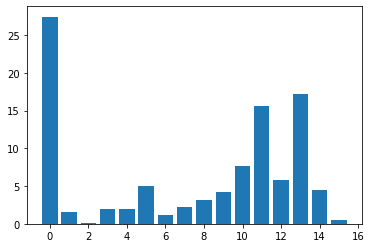

In [8]:
plt.bar([0,1,2,3,4,5,6,7,8,9, 10, 11,12,13,14, 15], model.get_feature_importance())
plt.show()

In [35]:
def mape_vectorized_v2(x):
    a = x['diff']
    b = x['diff_p']
    mask = a != 0
    return (np.fabs((a - b))/a)[mask].mean()

def mean_absolute_percentage_error(x):
    y_true = x['diff']
    y_pred = x['diff_p']
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [107]:
eps = 1e-6
preds = model.predict(eval_data)
df_merged_w_preds = df_merged['2019-11':].copy()
df_merged_w_preds['diff_p'] = pd.Series(preds, index=df_merged_w_preds.index)
df_merged_w_preds['error'] = abs(df_merged_w_preds['diff'] - df_merged_w_preds['diff_p'])
df_merged_w_preds['error rel'] = abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)
df_merged_w_preds['error rel lg'] = np.log(abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)*10 +1)
df_merged_w_preds['mape'] = df_merged_w_preds.apply(mean_absolute_percentage_error, axis=1)
df_merged_w_preds[['diff', 'diff_p', 'error', 'error rel', 'error rel lg']]

,diff,diff_p,error,error rel,error rel lg
2019-11-01 00:00:00,0.1,0.088380,0.011620,0.116200,0.771035
2019-11-01 03:00:00,-0.4,-0.028960,0.371040,0.927600,2.329811
2019-11-01 06:00:00,0.2,-0.042695,0.242695,1.213476,2.575262
2019-11-01 09:00:00,1.2,0.264930,0.935070,0.779226,2.173872
2019-11-01 12:00:00,-0.2,0.253109,0.453109,2.265545,3.163594
...,...,...,...,...,...
2021-02-28 09:00:00,-1.8,-1.043962,0.756038,0.420020,1.648698
2021-02-28 12:00:00,-0.7,-0.630731,0.069269,0.098955,0.687908
2021-02-28 15:00:00,-0.2,-0.775882,0.575882,2.879410,3.394310
2021-02-28 18:00:00,-0.3,-0.663677,0.363677,1.212255,2.574332


In [109]:
df_merged_w_preds[df_merged_w_preds['error rel'] > 5][['diff', 'diff_p', 'error', 'error rel', 'mape', 'error rel lg']]

,diff,diff_p,error,error rel,mape,error rel lg
2019-11-02 03:00:00,0.0,0.544479,0.544479,inf,inf,inf
2019-11-03 06:00:00,0.1,1.364470,1.264470,12.644702,1264.470119,4.847701
2019-11-05 12:00:00,0.2,1.235459,1.035459,5.177298,517.729664,3.965999
2019-11-05 15:00:00,-0.2,1.355221,1.555221,7.776103,777.610362,4.366418
2019-11-07 00:00:00,0.0,0.288654,0.288654,inf,inf,inf
...,...,...,...,...,...,...
2021-02-23 09:00:00,0.2,-1.153131,1.353131,6.765656,676.565501,4.229117
2021-02-23 18:00:00,0.0,-0.431996,0.431996,inf,inf,inf
2021-02-26 21:00:00,0.1,1.079159,0.979159,9.791593,979.159175,4.594270
2021-02-27 12:00:00,0.0,1.564173,1.564173,inf,inf,inf


In [93]:
df_merged_w_preds['error rel'].mean()

inf

In [15]:
df_merged_w_preds['error'].mean()

0.630077797786126

In [16]:
abs(df_merged_w_preds['diff']).mean()

0.7918516513264758

In [17]:
df_merged_w_preds['error'][df_merged_w_preds['abs_diff'] > 2].mean()

1.8831462500502412

In [214]:
abs(df_merged_w_preds['diff'][df_merged_w_preds['abs_diff'] > 2]).mean()

2.827210884353741

In [215]:
abs(df_merged_w_preds['diff'][df_merged_w_preds['abs_diff'] > 2]).var()

0.7432270990588015

In [132]:
df_merged_w_preds['true_preds'] = df_merged_w_preds['error'] < 0.5

In [133]:
idxs = df_merged_w_preds[df_merged_w_preds['true_preds']].index.values
test_slice = eval_data.loc[idxs]
test_slice_labels = df_merged_w_preds[df_merged_w_preds['true_preds']]['diff']

In [134]:
test_slice = Pool(data=test_slice, label=test_slice_labels, cat_features=cat_cols)

In [135]:
prediction_diff = model.get_feature_importance(type='LossFunctionChange', data=test_slice, prettified=True)
prediction_diff['perc'] = prediction_diff.iloc[:,1] / prediction_diff.iloc[0,1] * 100
prediction_diff.head(10)

,Feature Id,Importances,perc
0,T,0.365873,100.000000
1,T_sher,0.207352,56.673302
2,T_kal,0.134174,36.672270
3,T_sar,0.047298,12.927322
4,DD_,0.042744,11.682837
5,Nh,0.028349,7.748361
6,Po,0.019039,5.203723
7,N,0.015737,4.301335
8,three_mean,0.004747,1.297574
9,Ff,0.003248,0.887621


Возьмем выборку с большой разностью:

In [217]:
#
# try catboost reg
train_data = df_merged_c['2012':'2019-03'][df_merged_c['abs_diff'] > 1.9]
train_data = train_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
eval_data = df_merged_c['2019-11':]
eval_data = eval_data.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])
train_labels = df_merged_c['2012':'2019-03'][df_merged_c['abs_diff'] > 1.9]['diff']

C:\Users\Dima\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dima\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [220]:
model = CatBoostRegressor(iterations=1000, 
                           task_type="GPU",
                           devices='0:1')

model.fit(train_data,
          train_labels,
          verbose=False,
         cat_features=cat_cols)

In [221]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 832 entries, 2012-11-01 00:00:00 to 2019-02-28 15:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           832 non-null    float64
 1   Ff          832 non-null    float64
 2   N           832 non-null    float64
 3   Nh          454 non-null    float64
 4   Cl          832 non-null    int32  
 5   Po          832 non-null    float64
 6   U           831 non-null    float64
 7   Ch          832 non-null    object 
 8   Cm          832 non-null    object 
 9   H           832 non-null    object 
 10  RRR         832 non-null    object 
 11  DD_         832 non-null    object 
 12  T_kal       831 non-null    float64
 13  T_sher      832 non-null    float64
 14  T_sar       637 non-null    float64
 15  three_mean  636 non-null    float64
dtypes: float64(10), int32(1), object(5)
memory usage: 107.2+ KB


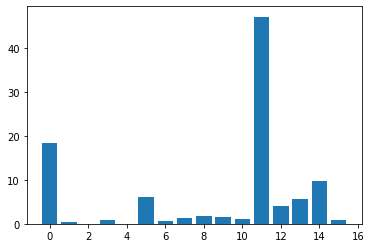

In [223]:
plt.bar([0,1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14, 15],model.get_feature_importance())
plt.show()

In [83]:
preds = model.predict(eval_data)
df_merged_w_preds = df_merged['2019-11':].copy()
df_merged_w_preds['diff_p'] = pd.Series(preds, index=df_merged_w_preds.index)
df_merged_w_preds['error'] = abs(df_merged_w_preds['diff'] - df_merged_w_preds['diff_p'])
df_merged_w_preds['error rel'] = abs(df_merged_w_preds['error']/df_merged_w_preds['diff'])
df_merged_w_preds

,T,T_a,Ff,N,Nh,Cl,Po,U,Ch,Cm,...,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3,diff_p,error,error rel
2019-11-01 00:00:00,2.1,2.0,3.0,100.0,100.0,7,738.5,85.0,NaN,"Высококучевые просвечивающие, полосами, либо о...",...,0.1,1.3,1.4,1.0,1.233333,0.866667,0.866667,0.088380,0.011620,0.116199
2019-11-01 03:00:00,2.6,3.0,3.0,100.0,100.0,7,737.8,85.0,NaN,"Высококучевые просвечивающие, полосами, либо о...",...,0.4,3.3,5.4,1.9,3.533333,-0.933333,0.933333,-0.028960,0.371040,0.927601
2019-11-01 06:00:00,4.2,4.0,2.0,100.0,100.0,0,738.4,92.0,NaN,NaN,...,0.2,10.7,4.7,2.7,6.033333,-1.833333,1.833333,-0.042695,0.242695,1.213475
2019-11-01 09:00:00,3.2,2.0,6.0,75.0,75.0,0,739.6,63.0,"Перистых, перисто-кучевых или перисто-слоистых...","Высококучевых, высокослоистых или слоисто-дожд...",...,1.2,10.7,1.2,3.1,5.000000,-1.800000,1.800000,0.264930,0.935070,0.779225
2019-11-01 12:00:00,1.8,2.0,5.0,75.0,75.0,0,740.8,68.0,"Перистых, перисто-кучевых или перисто-слоистых...","Высококучевых, высокослоистых или слоисто-дожд...",...,0.2,2.1,1.7,2.1,1.966667,-0.166667,0.166667,0.253109,0.453109,2.265546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,-24.0,3.0,100.0,100.0,7,755.8,79.0,NaN,Высокослоистые просвечивающие.,...,1.8,-26.5,-22.8,-27.2,-25.500000,-0.300000,0.300000,-1.043962,0.756038,0.420021
2021-02-28 12:00:00,-20.7,-20.0,4.0,100.0,0.0,7,753.9,81.0,Перистые (часто в виде полос) и перисто-слоист...,"Высококучевых, высокослоистых или слоисто-дожд...",...,0.7,-20.9,-20.4,-21.1,-20.800000,0.100000,0.100000,-0.630731,0.069269,0.098956
2021-02-28 15:00:00,-17.2,-17.0,5.0,100.0,40.0,7,751.9,80.0,Перистые (часто в виде полос) и перисто-слоист...,Высокослоистые непросвечивающие или слоисто-до...,...,0.2,-17.3,-16.4,-16.4,-16.700000,-0.500000,0.500000,-0.775882,0.575882,2.879411
2021-02-28 18:00:00,-17.3,-17.0,6.0,100.0,100.0,0,750.1,82.0,NaN,NaN,...,0.3,-17.6,-16.0,-16.9,-16.833333,-0.466667,0.466667,-0.663677,0.363677,1.212256


In [230]:
df_merged_w_preds['error'][df_merged_w_preds['abs_diff'] > 2].mean()

1.2220123393697555

### LightAutoML

On kaggle Kernel:

https://www.kaggle.com/dimka11/coursework-compare-temp/edit

In [9]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [10]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 200 # Time in seconds for automl run - UPDATED VALUE FOR UTILIZATION
TARGET_NAME = 'diff' # Target column name

In [11]:
task = Task('reg', loss='mae', metric='mae')

sklearn doesn't support in general case mae and will not be used.


In [12]:
roles = {'target': TARGET_NAME}

In [57]:
train_data_automl = df_merged_c['2012':'2019-03']
train_data_automl = train_data_automl.drop(columns=['abs_diff','diff_3','abs_diff_3', 'T_a', 'Cl', 'Cm', 'Ch', 'H', 'RRR'])

test_data_auto_ml = df_merged_c['2019-11':]
test_data_auto_ml = test_data_auto_ml.drop(columns=['diff','abs_diff','diff_3','abs_diff_3', 'T_a'])

In [14]:
# test_data_auto_ml['Cl'] = test_data_auto_ml['Cl'].astype(str)
# test_data_auto_ml['Ch'] = test_data_auto_ml['Ch'].astype(str)
# test_data_auto_ml['Cm'] = test_data_auto_ml['Cm'].astype(str)
# test_data_auto_ml['H'] = test_data_auto_ml['H'].astype(str)
# test_data_auto_ml['RRR'] = test_data_auto_ml['RRR'].astype(str)

In [48]:
# CHANGED TabularAutoML to TabularUtilizedAutoML for timeout utilization
automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb','lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )

In [49]:
oof_pred = automl.fit_predict(train_data_automl, roles = roles)

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 199.99100351333618 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (6652, 12)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 178.78000593185425 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -0.8968559653606689
Linear model: C = 5e-05 score = -0.8274194886347461
Linear model: C = 0.0001 score = -0.8008471635727255
Linear model: C = 0.0005 score = -0.7690420438371078
L

Time limit exceeded after calculating fold 2


Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Optuna may run 1 secs


I0525 03:29:33.666882  9300 _in_memory.py:69] A new study created in memory with name: no-name-b2d44298-c9f2-4bbc-85cc-3dec2176deb4


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 0.767076
[200]	valid's l1: 0.722707
[300]	valid's l1: 0.703502
[400]	valid's l1: 0.69491
[500]	valid's l1: 0.690124
[600]	valid's l1: 0.687466
[700]	valid's l1: 0.685393
[800]	valid's l1: 0.683512
[900]	valid's l1: 0.682156
[1000]	valid's l1: 0.681185
[1100]	valid's l1: 0.680099
[1200]	valid's l1: 0.679358
[1300]	valid's l1: 0.678765
[1400]	valid's l1: 0.678148
[1500]	valid's l1: 0.677874
[1600]	valid's l1: 0.677682
[1700]	valid's l1: 0.677566
[1800]	valid's l1: 0.677194
[1900]	valid's l1: 0.676812
[2000]	valid's l1: 0.676547
[2100]	valid's l1: 0.676061
[2200]	valid's l1: 0.675524
[2300]	valid's l1: 0.675401
[2400]	valid's l1: 0.675303
[2500]	valid's l1: 0.675252
[2600]	valid's l1: 0.675131
[2700]	valid's l1: 0.674997
[2800]	valid's l1: 0.675109
Early stopping, best iteration is:
[2696]	vali

I0525 03:30:06.981879  9300 study.py:1015] Trial 0 finished with value: -0.6749931895850798 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.6749931895850798.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 0.690337
[200]	valid's l1: 0.685042
[300]	valid's l1: 0.682594
[400]	valid's l1: 0.681677
[500]	valid's l1: 0.680079
[600]	valid's l1: 0.679157
[700]	valid's l1: 0.678533
[800]	valid's l1: 0.677939
[900]	valid's l1: 0.677568
[1000]	valid's l1: 0.677435
[1100]	valid's l1: 0.677249
[1200]	valid's l1: 0.676694
[1300]	valid's l1: 0.676545
[1400]	valid's l1: 0.676202
[1500]	valid's l1: 0.675923
[1600]	valid's l1: 0.675935
Early stopping, best iteration is:
[1512]	valid's l1: 0.675842

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 0.70239
[200]	valid's l1: 0.696872
[300]	valid's l1: 0.694496
[400]	valid's l1: 0.693709
[500]	valid's l1: 0.693335
[600]	valid's l1: 0.692958
[700]	valid's l1: 0.692

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score -0.6648390085542879
Blending, iter 0: score = -0.6646887701040805, weights = [0.32760295 0.26641172 0.40598536]
Blending, iter 1: score = -0.6646866277249021, weights = [0.33224913 0.25461632 0.4131345 ]
Blending, iter 2: score = -0.6646866294355562, weights = [0.33224913 0.25461632 0.4131345 ]
No score update. Terminated

Automl preset training completed in 148.80 seconds.


In [51]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

AttributeError: 'NoneType' object has no attribute 'set_index'

In [ ]:
test_pred = automl.predict(test_data_auto_ml)

In [81]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_pred.data[:, 0], df_merged_c['2019-11':]['diff'].values)

0.6148924688585684

### Кластеризация

In [255]:
df_merged_cluster = df_merged[['T', 'Ff', 'N', 'Nh', 'Cl', 'DD_']]

In [256]:
df_merged_cluster = conv_wind_label(df_merged_cluster, col_name='DD_')

In [257]:
df_merged_cluster['Nh'] = df_merged_cluster['Nh'].fillna(0)
df_merged_cluster['N'] = df_merged_cluster['N'].fillna(0)

In [258]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=4).fit(df_merged_cluster)

In [259]:
df_merged_cluster['cluster'] = pd.Series(clustering.labels_, index=df_merged_cluster.index)

In [260]:
# df_merged_cluster.cluster.value_counts()
# df_merged_cluster.groupby('DD_', as_index=False)['diff', 'abs_diff'].mean().sort_values('abs_diff', ascending=False)

KeyError: "Columns not found: 'diff', 'abs_diff'"

In [262]:
df_merged_9 = df_merged.copy()
df_merged_9['cluster'] = df_merged_cluster['cluster']

In [269]:
df_merged_9[df_merged_9['cluster'] == 2].groupby('DD_', as_index=False)['diff', 'abs_diff'].mean().sort_values('abs_diff', ascending=False)

,DD_,diff,abs_diff
0,Calm,-0.080000,1.360000
2,North,-0.693333,1.213333
4,West,0.636000,0.908000
3,South,0.577778,0.851852
1,East,-0.611111,0.655556


In [ ]:
# Feature imp diff